In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

#from scipy import stats
#from yellowbrick.regressor import ResidualsPlot, PredictionError

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

In [4]:
# Import data to Pandas DataFrame
data = pd.read_csv('spotify_tracks.csv')

# Drop columns
songs = data.drop(columns=['artist_id', 
                            'track_name', 
                            'track_duration_ms', 
                            'track_track_number', 
                            'track_explicit',
                            'track_album_release_date', 
                            'track_album_total_tracks',
                            'track_album_available_markets', 
                            'track_album_name', 
                            'track_album_id',
                            'track_album_available_markets_count',
                            'track_album_single',])

# Drop duplicate rows
songs.drop_duplicates('track_id', keep='first', inplace=True)

# Preivew data
print(songs.info())
songs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637265 entries, 0 to 682192
Data columns (total 15 columns):
track_id            637265 non-null object
track_popularity    637265 non-null int64
danceability        637265 non-null float64
energy              637265 non-null float64
key                 637265 non-null float64
loudness            637265 non-null float64
mode                637265 non-null float64
speechiness         637265 non-null float64
acousticness        637265 non-null float64
instrumentalness    637265 non-null float64
liveness            637265 non-null float64
valence             637265 non-null float64
tempo               637265 non-null float64
duration_ms         637265 non-null float64
time_signature      637265 non-null float64
dtypes: float64(13), int64(1), object(1)
memory usage: 77.8+ MB
None


,track_id,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0003Z98F6hUq7XxqSRM87H,26,0.733,0.711,1.0,-5.408,1.0,0.1580,0.08600,0.0000,0.4510,0.346,138.076,241667.0,4.0
1,0008brbqMd6r3WdmXEPbUq,1,0.263,0.203,2.0,-20.025,1.0,0.0325,0.88900,0.1130,0.3170,0.142,62.553,189795.0,5.0
2,0008ihzWSit1NmuXq2VBpE,11,0.510,0.228,10.0,-17.138,1.0,0.0299,0.91400,0.6960,0.0847,0.322,128.759,344867.0,4.0
3,000BARWwSRfyAAYOxPMD83,12,0.531,0.837,0.0,-4.391,1.0,0.2740,0.00683,0.0000,0.2250,0.067,145.878,128219.0,4.0
4,000CfxgH11DeiTY9oCvZLJ,30,0.648,0.273,11.0,-4.897,1.0,0.0472,0.09410,0.0924,0.0853,0.904,145.844,213693.0,4.0


In [5]:
songs.columns

Index(['track_id', 'track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'], dtype='object')

In [6]:
# Calculate Pearson's R-Value to check for linear relationship

songs.corr()['track_popularity'].sort_values(ascending=False)


track_popularity    1.000000
loudness            0.167253
energy              0.106122
danceability        0.091792
valence             0.050353
time_signature      0.038292
tempo               0.019250
key                 0.002758
mode               -0.003596
liveness           -0.008387
speechiness        -0.043375
duration_ms        -0.065189
acousticness       -0.095788
instrumentalness   -0.147148
Name: track_popularity, dtype: float64

In [7]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id', 'track_popularity'])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,15.5,danceability
1,19.1,energy
2,3.2,key
3,9.4,loudness
4,2.7,mode
5,1.9,speechiness
6,4.2,acousticness
7,1.9,instrumentalness
8,2.6,liveness
9,6.4,valence


In [8]:
# Calculate VIF to check for Multicollinearity
# select only columns with datatype int64 or float 64
songs_cleaned = songs.drop(columns=['track_id',
                                         'loudness', 
                                         'danceability', 
                                         'time_signature', 
                                         'energy',
                                         'tempo'
                                        ])
#cleaned_KC.select_dtypes(include=['int64','float64']).drop(axis=1, columns=['id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Score"] = [variance_inflation_factor(songs_cleaned.values, i) for i in range(songs_cleaned.shape[1])]

# label the scores with their related columns
vif["features"] = songs_cleaned.columns

vif.round(1)

,VIF Score,features
0,2.5,track_popularity
1,2.8,key
2,2.5,mode
3,1.7,speechiness
4,2.0,acousticness
5,1.5,instrumentalness
6,2.3,liveness
7,3.3,valence
8,3.3,duration_ms


In [9]:
songs2 = songs.drop(columns=['track_id',
                                         'loudness', 
                                         'danceability', 
                                         'time_signature', 
                                         'energy',
                                         'tempo'
                                        ])

In [10]:
# Added dummy columns for categeorical variables
songs2 = pd.get_dummies(songs2, columns=['mode', 'key'], drop_first=True)

In [26]:
#Define appropriate X and y
X = songs2[songs2.columns[1:-1]]
y = songs2.track_popularity

Text(0.5, 1.0, 'Linear Relationship Exists')

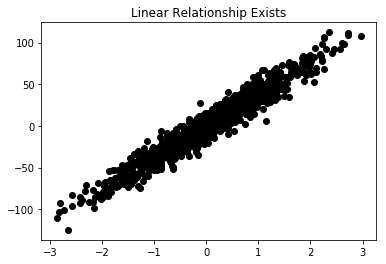

In [63]:
from sklearn.datasets.samples_generator import make_regression
X, y = make_regression(n_samples=1000, n_features=1, noise=10)

plt.plot(X, y, 'o', color='black');
plt.title("Linear Relationship Exists")

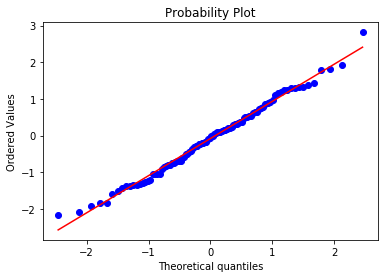

In [46]:
import scipy.stats as stats

stats.probplot(X[:,0], dist="norm", plot=plt)
plt.show()

In [47]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [ ]:
# Normalize the continuous variable data
X_train['speechiness'] = X_train.iloc[:, 0:1].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train['acousticness'] = X_train.iloc[:, 1:2].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train['instrumentalness'] = X_train.iloc[:, 2:3].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train['liveness'] = X_train.iloc[:, 3:4].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train['valence'] = X_train.iloc[:, 4:5].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)
X_train['duration_ms'] = X_train.iloc[:, 5:6].apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)

In [48]:
reg = sm.OLS(y_train, X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     2241.
Date:                Sun, 20 Oct 2019   Prob (F-statistic):           9.48e-60
Time:                        13:19:33   Log-Likelihood:                -311.85
No. Observations:                  80   AIC:                             625.7
Df Residuals:                      79   BIC:                             628.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            60.4949      1.278     47.342      0.000      57.951      63.038
==============================================================================
Omnibus:                        0.305   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.858   Jarque-Bera (JB):                0.066
Skew:                          -0.058   Prob(JB):                        0.968
Kurtosis:                       3.078   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pred_val = reg.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pred_val, residuals, alpha = 0.3)

In [50]:
# Ridge Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(X_train, y_train)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.01}
-157.55406200113129


In [51]:
# Lasso Regression
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 100, 1000]}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)

lasso_regressor.fit(X_train, y_train)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-15}
-157.55427026159765
